In [1]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import pandas as pd

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma

In [6]:
# Create initial State, Input and Measurement Vector Variables
x0 = VariableVector(cAl2O3=2.3, deltag_rate=0.00, deltaI=0.0)
u0 = VariableVector(g0=0.0, ACD=2.60, I0=126500.0)
z0 = VariableVector(Vcell=4.465858, Icell=126500.0)

In [7]:
# define the time constant for the delta g rate model
# kdeltag = bbcell.kdiss
kdeltag = 0.001

In [8]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(3, dtype=float))
# first order layer has a few elements dependent on dT
F.set_array_layer(1, np.array([[0.0, 100/bbcell.m, -gamma/bbcell.m],
                               [0.0, -kdeltag, 0.0],
                               [0.0, 0.0, 0.0]]))

True

In [9]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(3, 3, 1)
G.set_array_layer(0, np.zeros((3,3)))
G.set_array_layer(1, np.identity(3, dtype=float))

True

In [10]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(3, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]))

True

In [11]:
# Define the UKF noise standard deviations - Some tuning already applied relative to R - comments show original settings
q1std = 0.01         # 0.0002 alumina concentration variation (wt%) 0.01
q2std = 0.001        # 0.0002 alumina feed mass discrepancy (kg/sec) 0.0005
q3std = 30           # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(3, 3, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0],
                               [0.0, q2std**2, 0.0],
                               [0.0, 0.0, q3std**2]]))

True

In [12]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 5           # 20 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))

True

In [13]:
# initialise the revised 3 state model
from Refactor.UKFClass import DiscreteModel
alumina3state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [14]:
# normalisation vectors
xnorm = VariableVector(cAl2O3=1.0, deltag_rate=10.0, deltaI=0.01)
unorm = VariableVector(g0=1.0, ACD=10,  I0=0.01)
znorm = VariableVector(Vcell=1.0, Icell=0.01)

In [15]:
# Import the UKF class and supporting functions
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack, ukf_execute, ukf_gen_samples
from Refactor.SimClass import SimCell, plot_xsim, plot_usim, plot_zsim

In [16]:
def LoadData(filename: str):
    # This is a quick loader - not finalised
    celldata = pd.read_csv(filename, sep=',')
    npcelldata = celldata.to_numpy()
    return npcelldata

def ExtractData(CellData, cycle, u0: VariableVector, z0: VariableVector):
    subset = (npdata[:,0] == cycle)
    CycleData = CellData[subset, :]
    dims = np.shape(CycleData)
    tsteps = dims[0]
    udim = np.size(u0.vector)
    zdim = np.size(z0.vector)
    u = np.zeros((tsteps, udim, 1))
    z = np.zeros((tsteps, zdim, 1))
    ACD = u0.variable('ACD')
    I0 = u0.variable('I0')
    for i in range(tsteps):
        VCell = CycleData[i, 1]
        ICell = CycleData[i, 2]
        g0 = CycleData[i, 4]
        ACD = ACD + CycleData[i, 5]
        uobs = np.array([[g0], [ACD], [I0]])
        u[i] = np.copy(uobs)
        zobs = np.array([[VCell], [ICell]])
        z[i] = np.copy(zobs)
    return u, z

In [17]:
# load in actual data for input and observation
file = "C:/Python Files/AluminaConcEstimator/DataImport/excelproto3.csv"
npdata = LoadData(file)

### Filler

### Visualise UKF Execution on Cell Data for Single OF-Nom-UF Cycle

In [42]:
# Define which samplecycle to evaluate and initial guestimate of starting concentration and ACD
dT = 5
samplecycle = 4
x0.setvariable('cAl2O3', 2.5)
u0.setvariable('ACD', 2.7)

True

In [43]:
# Extract and pre-process that data
utrue, ztrue = ExtractData(npdata, samplecycle, u0, z0)

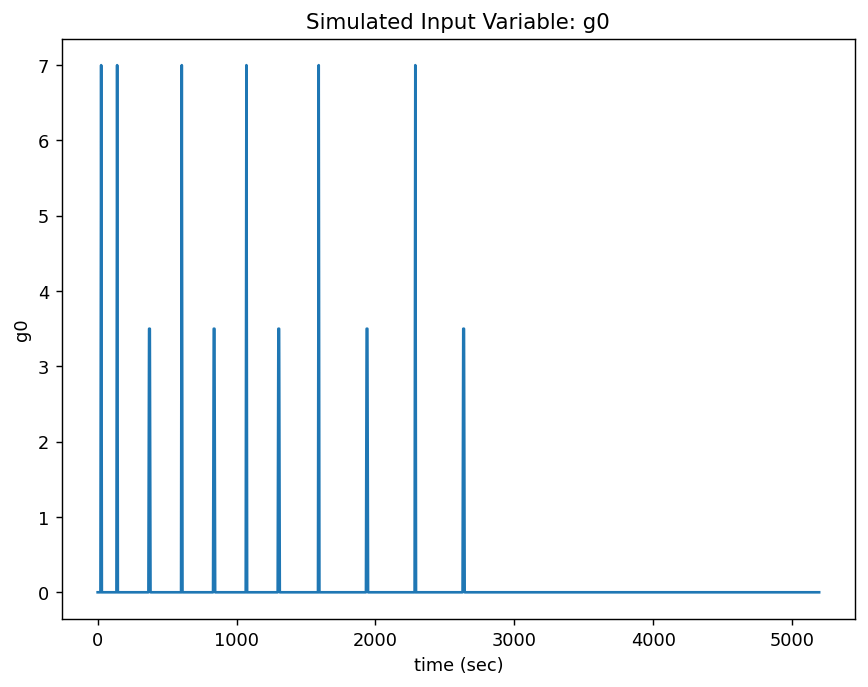

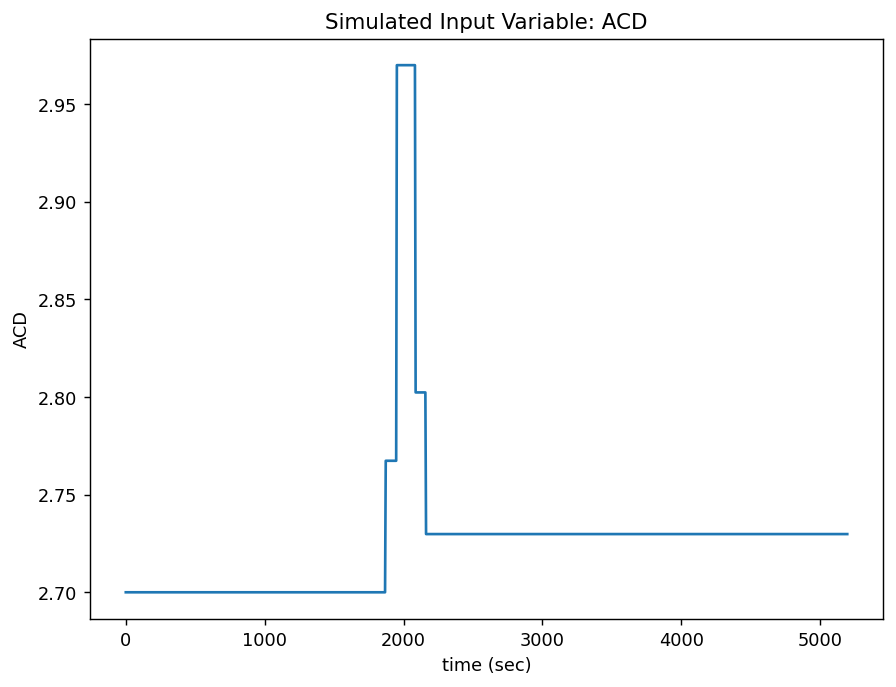

In [44]:
# plotting of the input as loaded - hijacking the simulation plot functions
plot_usim(list(u0.dictionary.keys()), utrue, dT, 2)

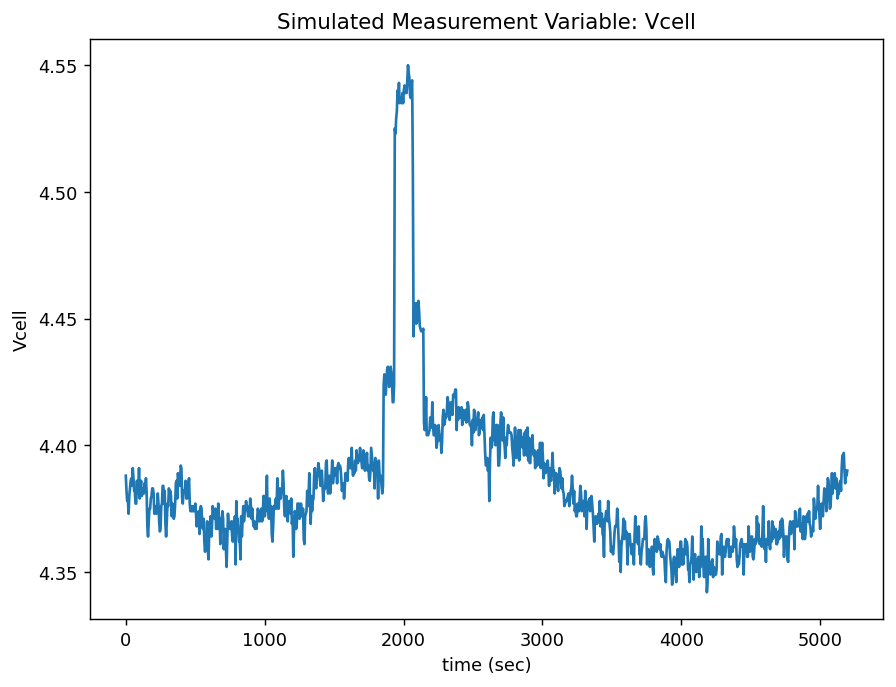

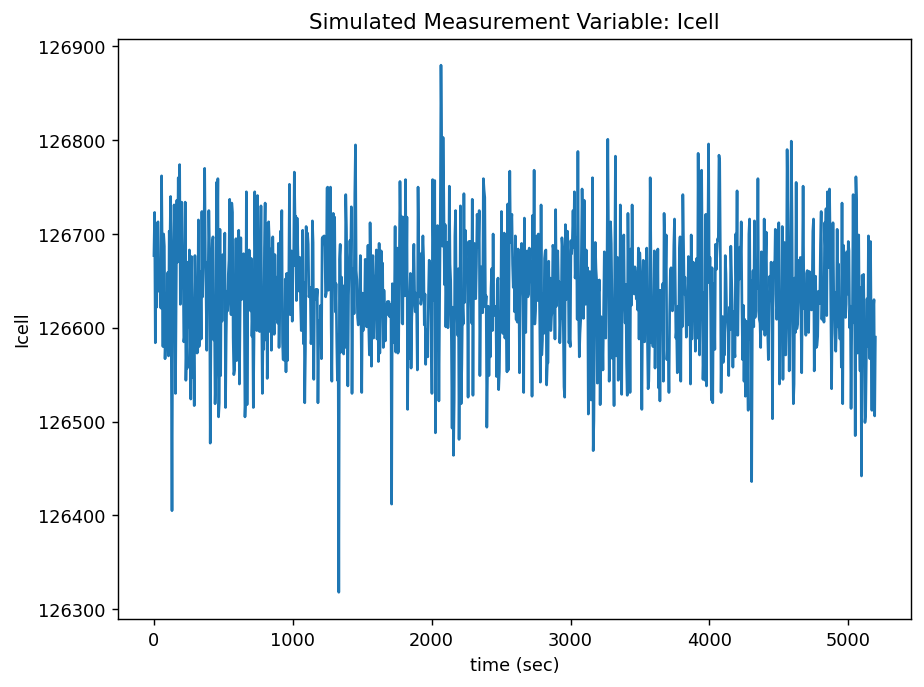

In [45]:
# plotting of the measurements as loaded - hijacking the simulation plot functions
plot_zsim(list(z0.dictionary.keys()), ztrue, dT, 0)

In [46]:
# Create an instance of the unscented Kalman Filter using the Revised 3-state model
UKF3state = UKF(alumina3state, bbcell, x0, dT, xnorm=xnorm, unorm=unorm, znorm=znorm)

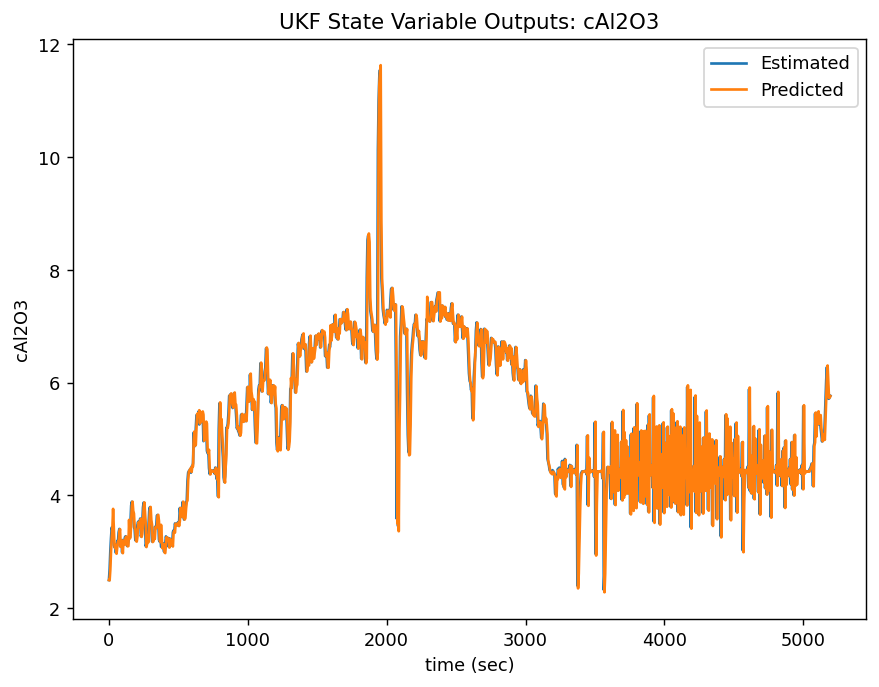

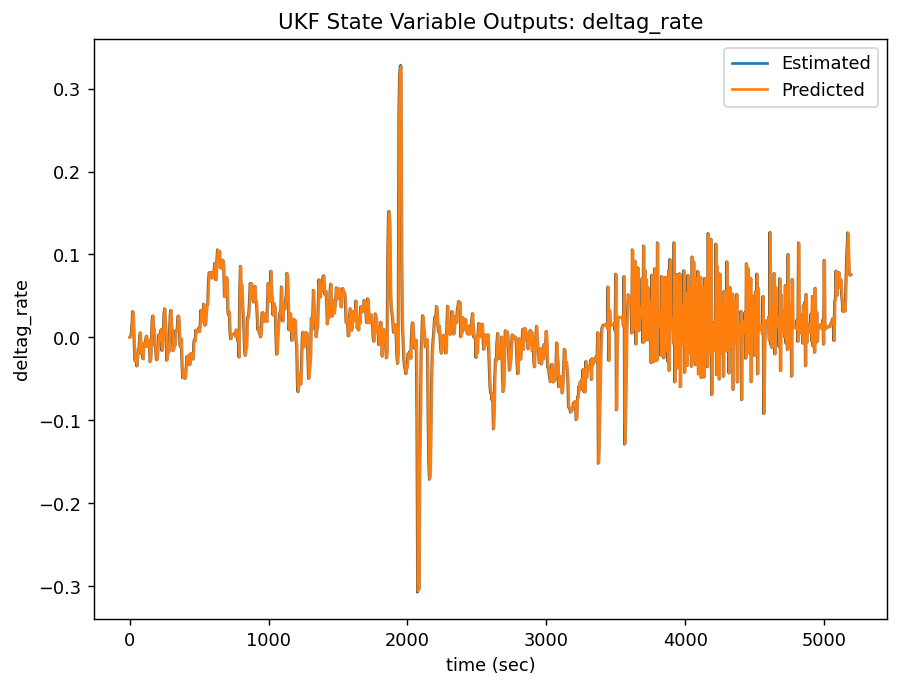

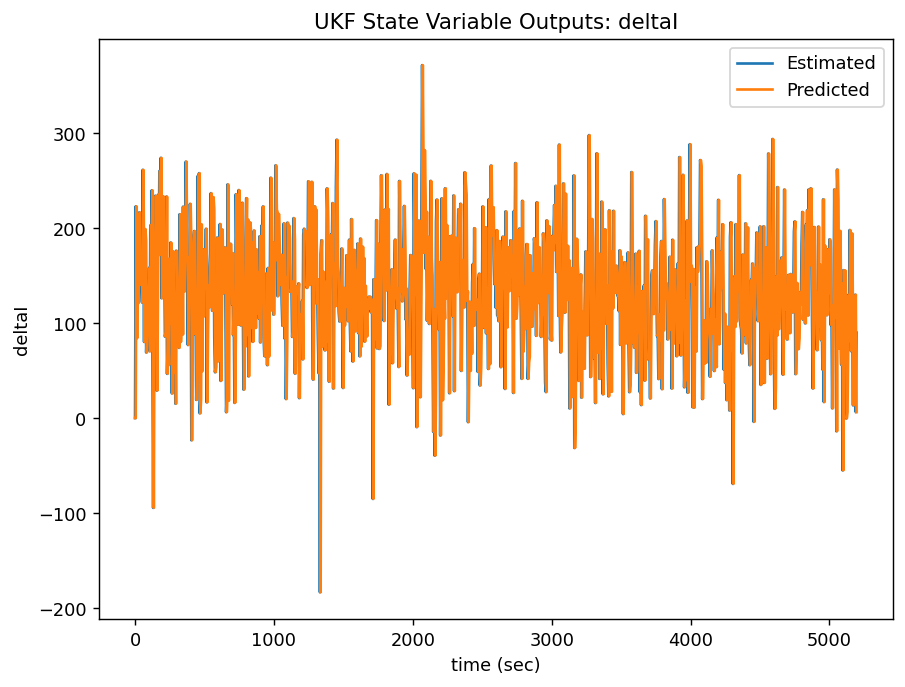

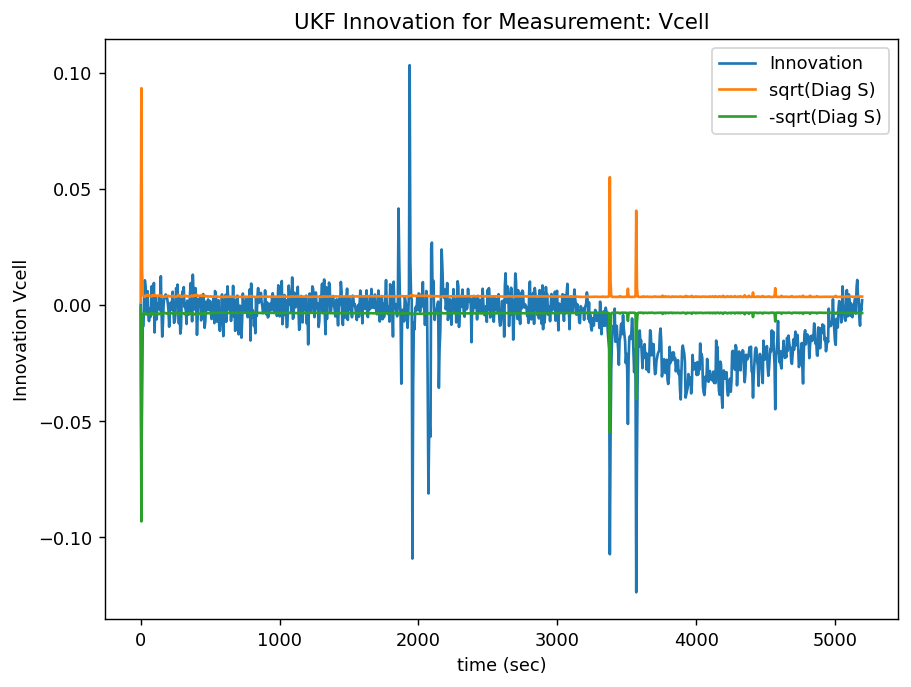

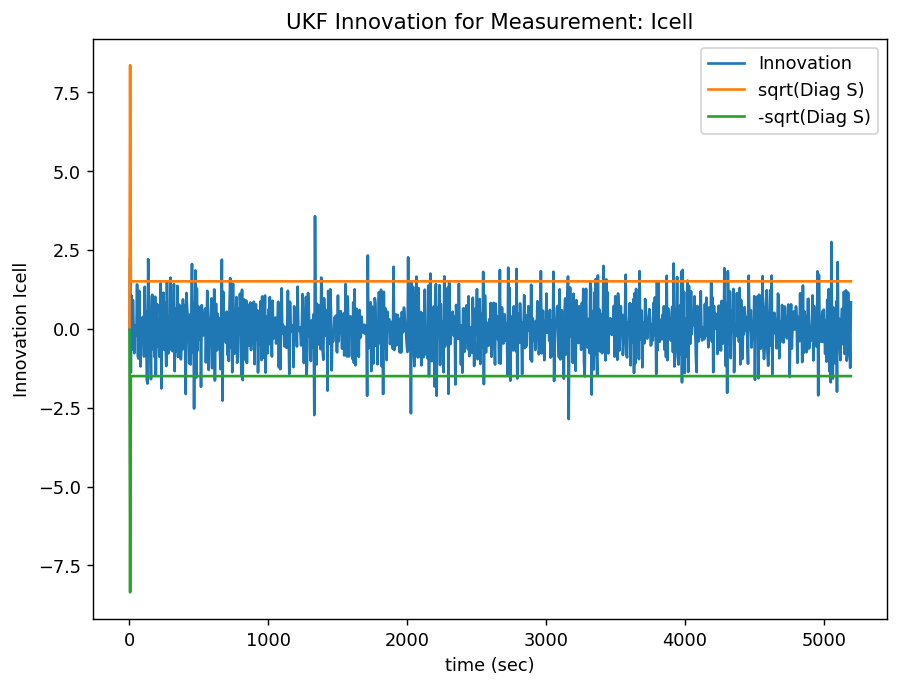

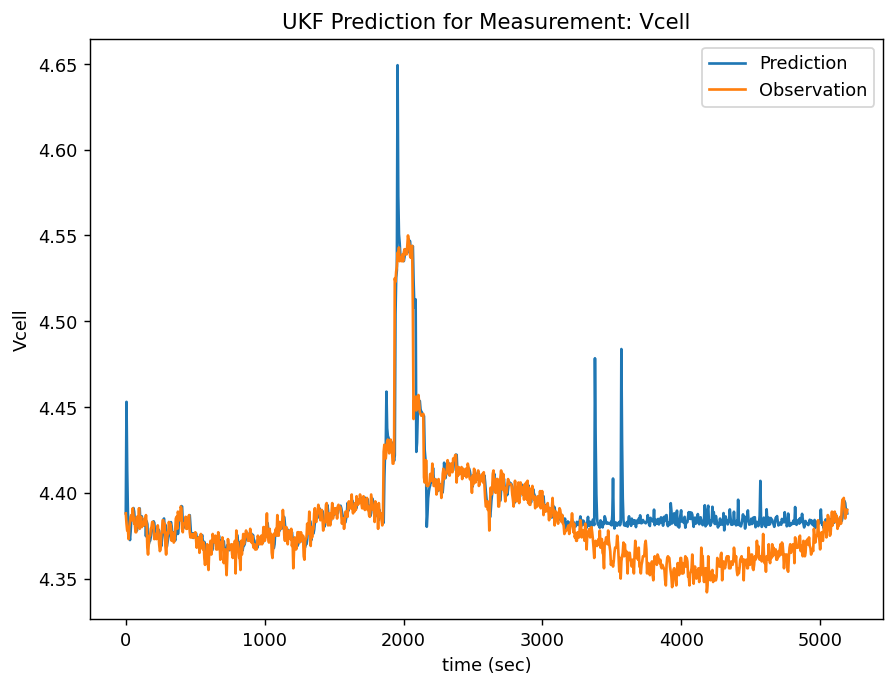

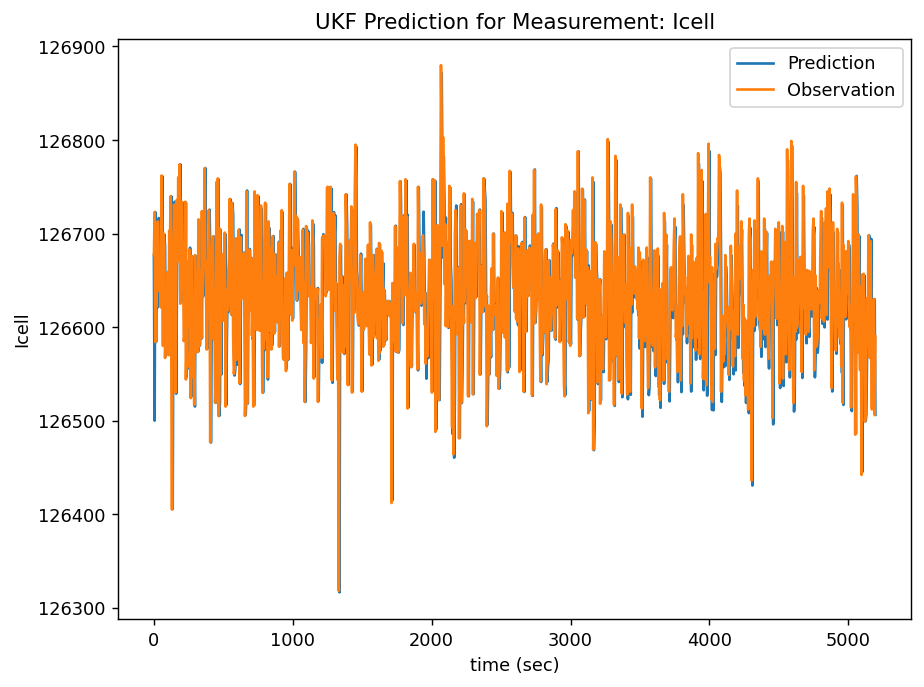

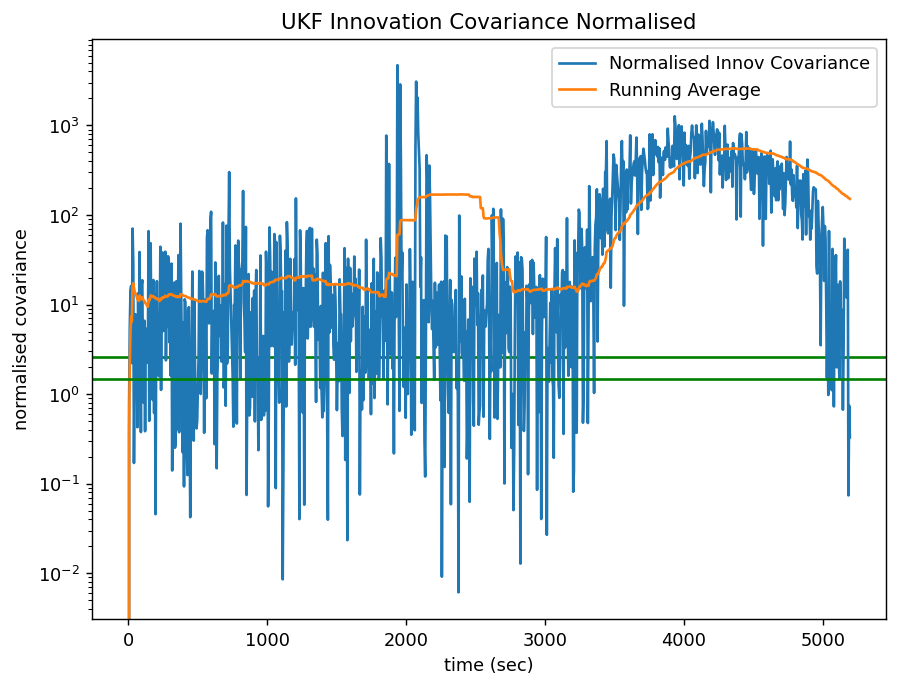

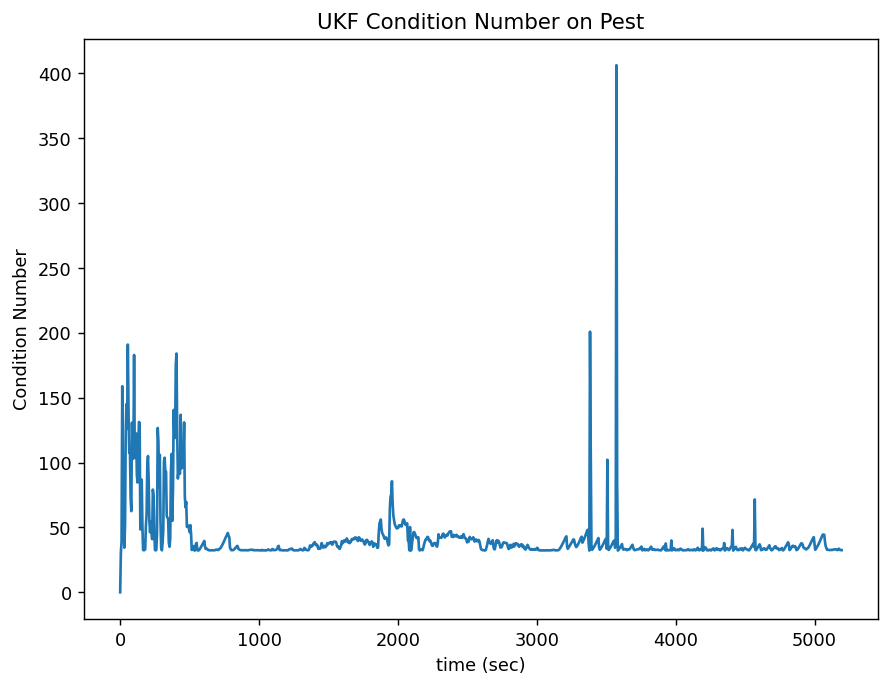

In [47]:
# Run the imported data through the UKF 3 state model 
xest, Pest, xpred, Ppred, innov, innov_cov, cond = ukf_execute(UKF3state, ztrue, utrue, dT,
                                                               plotresult=True, xtrue=None)